In [1]:
"""Temporary fix for importing modules from parent directory"""
import os
import sys

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from varitop.misc import euler_rule
from varitop.problem import OptiProblem
from varitop.integrator import DelIntegrator

from darli.modeling.robot import Robot as RobotModel
from darli.backend import CasadiBackend

from robot_descriptions import z1_description

import matplotlib.pyplot as plt
import casadi as cs
import numpy as np

Matplotlib created a temporary cache directory at /tmp/matplotlib-ovtbfasx because the default path (/home/mambauser/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


## Initial Conditions

In [3]:
q_init = np.zeros(6)
desired_pos = np.array([0.2, 0.2, 0.36])
v_max = 1.5
u_max = 5
nodes = 150
tf = 1.5
dt = tf / nodes

In [4]:
darli_model = RobotModel(CasadiBackend(z1_description.URDF_PATH))
darli_model.add_body(bodies_names={'ee': 'link06'})

In [5]:
nq = darli_model.nq
nu = darli_model.nu

## Variational Integrator

In [6]:
di = DelIntegrator()
di.nq = nq
di.nu = nu
di.rule = euler_rule
di.lagrangian = darli_model.lagrangian

In [7]:
f = cs.Function("f", [darli_model.q, darli_model.v, darli_model._u], [darli_model._u])

In [8]:
di.add_generalized_forces([f])

## Optimization Problem

In [9]:
problem = OptiProblem()
problem.nodes = nodes
problem.nq = nq
problem.nu = nu
problem.dt = dt
problem.integrator = di

In [10]:
q = problem.q
u = problem.u

In [11]:
ee_pos = darli_model.body('ee').position
pos = cs.Function('pos', [darli_model.q], [ee_pos], ['q'], ['pos'])

In [12]:
problem.add_initial_constraint(q_init)
problem.add_intermidiate_constraint(q[0, :].T == q[1, :].T)
problem.add_intermidiate_constraint(pos(q[-1, :]) == desired_pos)
problem.add_terminal_constraint(q[-2, :].T)

In [13]:
problem.add_limits(darli_model.q_min, q.T, darli_model.q_max)
problem.add_limits(-v_max, (q[1:, :] - q[:-1, :]).T / dt, v_max)
problem.add_limits(-u_max, u.T, u_max)

In [14]:
# stage cost 
for i in range(nodes - 1):
    problem.add_intermidiate_cost(1e-2*cs.sumsqr(q[i,:])*dt)
    problem.add_intermidiate_cost(5e-2*cs.sumsqr((q[i+1,:] - q[i,:])/dt)*dt)
    problem.add_intermidiate_cost(0.005*cs.sumsqr(u[i,:])*dt)
    
# Terminal cost 
problem.add_terminal_cost(5e-2*cs.sumsqr(q[-1,:]))
problem.add_terminal_cost(10e-2*cs.sumsqr((q[-1,:] - q[-2,:])/dt))


In [15]:
# Build all residuals, include constraints and limits
problem.build()

## Solver
For now I do not see any reason to wrap solver, since it is two calls:

In [16]:
problem.problem.solver('ipopt')
problem.problem.solve()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    16916
Number of nonzeros in inequality constraint Jacobian.:     3582
Number of nonzeros in Lagrangian Hessian.............:     9408

Total number of variables............................:     1794
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      909
Total number of inequality c

OptiSol(Opti {
  instance #0
  #variables: 2 (nx = 1794)
  #parameters: 0 (np = 0)
  #constraints: 155 (ng = 3597)
  CasADi solver allocated.
  CasADi solver was called: Solve_Succeeded
})

## Visualization of the solution

In [17]:
q_opt = problem.problem.value(q)
u_opt = problem.problem.value(u)

In [18]:
pos(q_opt[-1]), desired_pos

(DM([0.2, 0.2, 0.36]), array([0.2 , 0.2 , 0.36]))

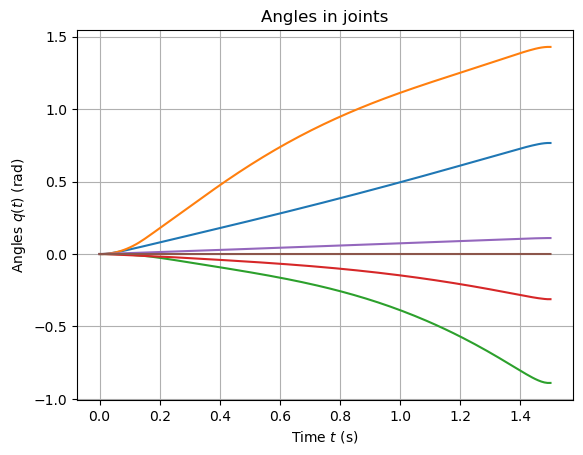

In [19]:
t = np.linspace(0, tf, nodes)

plt.title(r'Angles in joints')
plt.plot(t, q_opt)
plt.grid(True)
plt.ylabel(r'Angles $q(t)$ (rad)')
plt.xlabel(r'Time $t$ (s)')
plt.show()

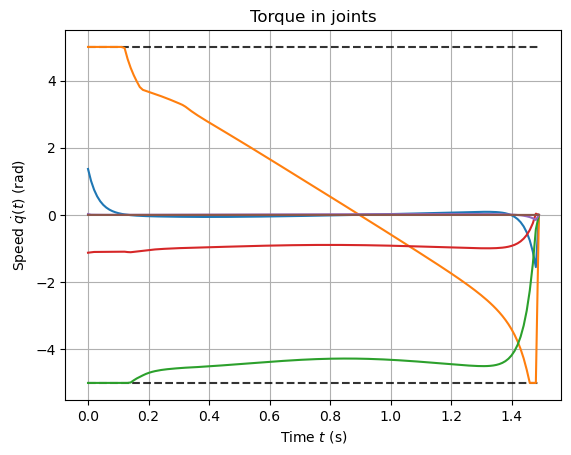

In [20]:

plt.title(r'Torque in joints')
plt.hlines(-u_max, 0, tf-dt, color = 'black', linestyle = '--', alpha = 0.8)
plt.hlines(u_max, 0, tf-dt, color = 'black', linestyle = '--', alpha = 0.8)
plt.plot(t[:-1], u_opt)
plt.grid(True)
plt.ylabel(r'Speed $\dot{q}(t)$ (rad)')
plt.xlabel(r'Time $t$ (s)')
plt.show()